<a href="https://colab.research.google.com/github/yehezkielgunawan/thesis-risk-classification/blob/main/RF_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [29]:
!pip install scikit-learn
!pip install scikit-plot

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


# Load the new dataset for sentiment classification
new_data = pd.read_excel('/content/gdrive/My Drive/Tesis/Compiled Classification Dataset.xlsx')
sentences = new_data['content'].tolist()

# Load the exported word embeddings
embeddings = np.load('/content/gdrive/My Drive/Tesis/bert_embeddings.npy')

In [31]:
new_data.head(5)

,Unnamed: 0,content,priority_score,problem_domain
0,1,"Sorry, including the expensive price + apk usi...",2,0
1,2,Setelah install terus pas buka aplikasi ngebla...,3,1
2,3,"gak bisa submit pada saat verifikasi data, pad...",3,1
3,4,Aplilasi restart mulu,3,0
4,5,"udah mahal , makanan ga enak, banyak lalat",2,1


In [32]:
# Check the label distributions
priority_score_distribution = new_data['priority_score'].value_counts()
problem_domain_distribution = new_data['problem_domain'].value_counts()

print("Label priority_score Distribution:")
print(priority_score_distribution)

print("Label problem_domain Distribution:")
print(problem_domain_distribution)

Label priority_score Distribution:
3    277
2    275
1    148
Name: priority_score, dtype: int64
Label problem_domain Distribution:
0    570
1    130
Name: problem_domain, dtype: int64


In [33]:
# Assuming the labels for the new dataset are stored in two columns: 'label1' and 'label2'
priority_score = new_data['priority_score'][:len(embeddings)]
problem_domain = new_data['problem_domain'][:len(embeddings)]

# Truncate the embeddings to match the number of rows in new_data
embeddings = embeddings[:len(priority_score)]

# Define the class weights for label 1
# class_weights1 = {
#     1: 5,  # Class 1 weight
#     2: 1,  # Class 2 weight
#     3: 1   # Class 3 weight
# }

# Define the class weights for label 2
# class_weights2 = {
#     0: 1,  # Class 0 weight
#     1: 5   # Class 1 weight
# }

# Split the data into training and testing sets
X_train, X_test, y_train1, y_test1, y_train2, y_test2 = train_test_split(embeddings, priority_score, problem_domain, test_size=0.3, random_state=50)

In [34]:
# Define the parameter grid for Grid Search for priority_score
param_grid1 = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Define the parameter grid for Grid Search for problem_domain
param_grid2 = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Initialize the Random Forest classifiers
rf_classifier1 = RandomForestClassifier(class_weight="balanced", random_state=50)
rf_classifier2 = RandomForestClassifier(class_weight="balanced", random_state=50)

# Perform Grid Search to find the best hyperparameters for priority_score
grid_search1 = GridSearchCV(estimator=rf_classifier1, param_grid=param_grid1, cv=5)
grid_search1.fit(X_train, y_train1)

# Perform Grid Search to find the best hyperparameters for problem_domain
grid_search2 = GridSearchCV(estimator=rf_classifier2, param_grid=param_grid2, cv=5)
grid_search2.fit(X_train, y_train2)

# Get the best classifiers with the optimal hyperparameters
best_classifier1 = grid_search1.best_estimator_
best_classifier2 = grid_search2.best_estimator_

# Evaluate the best classifiers on the test sets for priority_score
y_pred1 = best_classifier1.predict(X_test)
classification_rep1 = classification_report(y_test1, y_pred1)

# Evaluate the best classifiers on the test sets for problem_domain
y_pred2 = best_classifier2.predict(X_test)
classification_rep2 = classification_report(y_test2, y_pred2)

print("Best Hyperparameters for priority_score:", grid_search1.best_params_)
print("Classification Report for priority_score:")
print(classification_rep1)

print("Best Hyperparameters for problem_domain:", grid_search2.best_params_)
print("Classification Report for problem_domain:")
print(classification_rep2)

Best Hyperparameters for priority_score: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}
Classification Report for priority_score:
              precision    recall  f1-score   support

           1       0.29      0.05      0.09        37
           2       0.43      0.54      0.48        83
           3       0.43      0.48      0.46        90

    accuracy                           0.43       210
   macro avg       0.38      0.36      0.34       210
weighted avg       0.41      0.43      0.40       210

Best Hyperparameters for problem_domain: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 50}
Classification Report for problem_domain:
              precision    recall  f1-score   support

           0       0.77      0.93      0.84       163
           1       0.20      0.06      0.10        47

    accuracy                           0.73       210
   macro avg       0.49      0.50      0.47       210
weighted avg       0.65      0.73      0.68       21

In [35]:
# Function to plot confusion matrix
def plot_confusion_matrix_3x3(cm, title):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap='Blues', xticklabels=[1,2,3], yticklabels=[1,2,3])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

def plot_confusion_matrix_2x2(cm, title):
    plt.figure(figsize=(2, 2))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

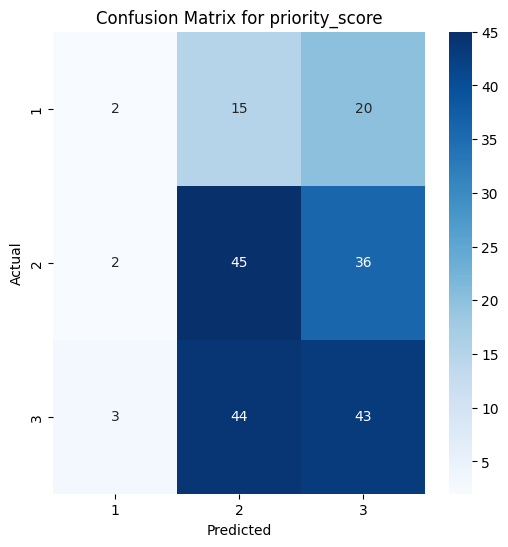

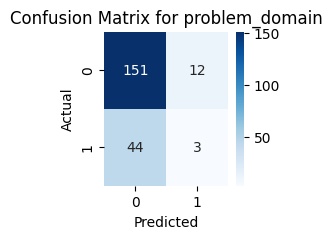

In [36]:
# Calculate confusion matrix for Label 1
cm1 = confusion_matrix(y_test1, y_pred1)

# Plot confusion matrix for Label 1
plot_confusion_matrix_3x3(cm1, title="Confusion Matrix for priority_score")

# Calculate confusion matrix for Label 2
cm2 = confusion_matrix(y_test2, y_pred2)

# Plot confusion matrix for Label 2
plot_confusion_matrix_2x2(cm2, title="Confusion Matrix for problem_domain")